In [5]:
import os
import numpy as np
import scipy.io
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')




Mounted at /content/drive


In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy.io

# Path to your dataset and .mat files
dataset_path = '/content/drive/My Drive/EX4_machine_learning/jpg'
labels_path = '/content/drive/My Drive/EX4_machine_learning/imagelabels.mat'

# Load .mat files
labels_mat = scipy.io.loadmat(labels_path)

# Extract labels
labels = labels_mat['labels'][0]

# Prepare the filename and labels mapping
file_labels = {f'image_{i:05d}.jpg': str(labels[i-1]) for i in range(1, 8190)}  # Convert labels to string
filenames = list(file_labels.keys())
file_classes = list(file_labels.values())

# Create a DataFrame with filenames and classes
df = pd.DataFrame({
    'filename': filenames,
    'class': file_classes
})

# Split the data into training and temp data first, temp will then be split into validation and test
train_df, temp_df = train_test_split(df, test_size=0.5, random_state=42)  # 50% training, 50% temp
validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split temp into 50% validation and 50% test

# Prepare the data generators
datagen = ImageDataGenerator(rescale=1./255)

def create_generator(dataframe):
    return datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=dataset_path,
        x_col='filename',
        y_col='class',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

# Create generators using the DataFrames
train_generator = create_generator(train_df)
validation_generator = create_generator(validation_df)
test_generator = create_generator(test_df)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/EX4_machine_learning/imagelabels.mat'

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [5]:
# Load the VGG19 model pre-trained on ImageNet data
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers in the base model to prevent them from being trainable
for layer in base_model.layers:
    layer.trainable = False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Add custom layers on top of the base model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model

x = Flatten()(base_model.output)
x = Dense(2048, activation='relu')(x)  # Increased from 1024 to 2048
x = Dropout(0.6)(x)  # Increased dropout to prevent overfitting
x = Dense(1024, activation='relu')(x)  # Additional Dense layer
predictions = Dense(102, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [7]:
from tensorflow.keras.optimizers import Adam

# Correct way to set the learning rate in TensorFlow 2.x
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
# Assuming 'train_generator', 'validation_generator', and 'test_generator' are already set up
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2639s 21s/step - accuracy: 0.0484 - loss: 4.5345 - val_accuracy: 0.2560 - val_loss: 3.5562
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 35s 275ms/step - accuracy: 0.2657 - loss: 3.2947 - val_accuracy: 0.4152 - val_loss: 2.5459
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 35s 272ms/step - accuracy: 0.4403 - loss: 2.3482 - val_accuracy: 0.5110 - val_loss: 2.0346
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 271ms/step - accuracy: 0.5577 - loss: 1.7558 - val_accuracy: 0.5471 - val_loss: 1.7412
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 36s 282ms/step - accuracy: 0.6485 - loss: 1.3278 - val_accuracy: 0.6116 - val_loss: 1.5196
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 35s 274ms/step - accuracy: 0.7128 - loss: 1.0796 - val_accuracy: 0.6292 - val_loss: 1.4749
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 37s 286ms/step - accuracy: 0.7697 - loss: 0.8887 - val_accuracy: 0.6580 - val_loss: 1.3191
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 35s 273ms/step - accuracy: 0.8183 - loss: 0

In [9]:
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the results
print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)

64/64 ━━━━━━━━━━━━━━━━━━━━ 866s 14s/step - accuracy: 0.6938 - loss: 1.1464
Test accuracy: 0.68994140625
Test loss: 1.127793788909912


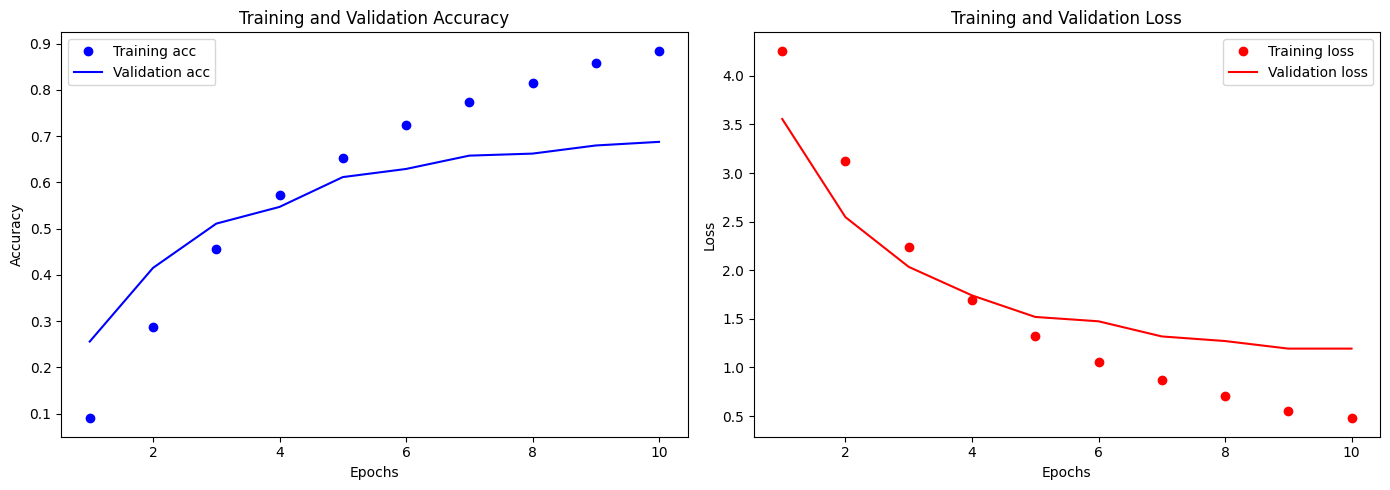

In [10]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from your model.fit call
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy per epoch
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import scipy.io


# Path to your dataset and .mat files
dataset_path = '/content/drive/My Drive/EX4_machine_learning/jpg'
labels_path = '/content/drive/My Drive/EX4_machine_learning/imagelabels.mat'

# Load labels from .mat file
labels_mat = scipy.io.loadmat(labels_path)
labels = labels_mat['labels'][0]

# Prepare the filename and labels mapping
file_labels = {f'image_{i:05d}.jpg': labels[i-1] - 1 for i in range(1, 8190)}  # Convert labels to 0-based index
filenames = list(file_labels.keys())
file_classes = list(file_labels.values())

# Create a DataFrame with filenames and classes
df = pd.DataFrame({
    'filename': filenames,
    'class': file_classes
})

# Split the data into training, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.5, random_state=42)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Define a custom dataset class for PyTorch
class FlowerDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

# Define image transformations for YOLOv5
transform = transforms.Compose([
    transforms.Resize((640, 640)),  # Resize the image to 640x640 for YOLOv5
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet's mean and std
])

# Create dataset instances
train_dataset = FlowerDataset(train_df, dataset_path, transform=transform)
validation_dataset = FlowerDataset(validation_df, dataset_path, transform=transform)
test_dataset = FlowerDataset(test_df, dataset_path, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [52]:
import os
import pandas as pd
import scipy.io
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim

# Path to your dataset and .mat files
dataset_path = '/content/drive/My Drive/EX4_machine_learning/jpg'
labels_path = '/content/drive/My Drive/EX4_machine_learning/imagelabels.mat'

# Load labels from .mat file
labels_mat = scipy.io.loadmat(labels_path)
labels = labels_mat['labels'][0]

# Prepare the filename and labels mapping
file_labels = {f'image_{i:05d}.jpg': labels[i-1] - 1 for i in range(1, 8190)}
filenames = list(file_labels.keys())
file_classes = list(file_labels.values())

# Create a DataFrame with filenames and classes
df = pd.DataFrame({
    'filename': filenames,
    'class': file_classes
})

# Split the data
train_df, temp_df = train_test_split(df, test_size=0.5, random_state=42)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Define a custom dataset class for PyTorch
class FlowerDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

# Image transformations
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Dataset and DataLoader setup
train_dataset = FlowerDataset(train_df, dataset_path, transform=transform)
validation_dataset = FlowerDataset(validation_df, dataset_path, transform=transform)
test_dataset = FlowerDataset(test_df, dataset_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Custom YOLOv5 model for classification
class CustomYOLOv5(nn.Module):
    def __init__(self, num_classes=102):
        super(CustomYOLOv5, self).__init__()
        # Load a pre-trained YOLOv5 model
        self.backbone = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
        # Replace the head for classification
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(1280, num_classes)  # Adjust the in_features accordingly
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

# Initialize model, loss, and optimizer
model = CustomYOLOv5(num_classes=102)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')

        # Validation phase could be added here

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_model(model, criterion, optimizer)


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 v7.0-398-g5cdad892 Python-3.11.11 torch-2.5.1+cu124 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/content/yolov5/yolov5/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


AttributeError: 'list' object has no attribute 'size'